In [1]:
# Library Imports (Consolidated and Organized)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from textblob import TextBlob
import warnings
from sklearn.feature_extraction.text import CountVectorizer
#import textstat
import pickle
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [3]:
data =pd.read_csv("WELFake_Dataset.csv")
data.shape

(72134, 4)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [5]:
data.drop(columns=['Unnamed: 0'],axis=1,inplace=True)

In [6]:
data

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
...,...,...,...
72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


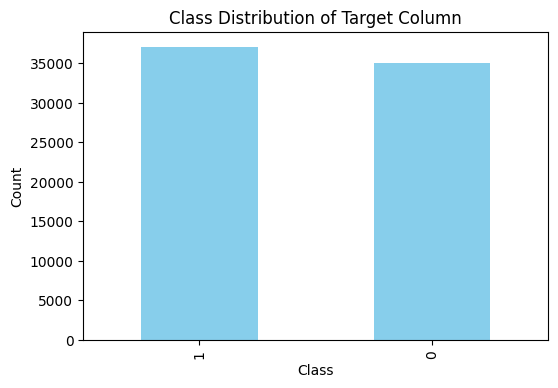

In [7]:
class_counts = data['label'].value_counts()
plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Class Distribution of Target Column')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [8]:
data = data.dropna()

print(f"number of missing values in label column: {data['label'].isna().sum()}")
print(f"number of missing values in text column: {data['text'].isna().sum()}")
print(f"number of missing values in title column: {data['text'].isna().sum()}")

number of missing values in label column: 0
number of missing values in text column: 0
number of missing values in title column: 0


In [9]:
# Filtering the dataset
filtered_data_real = data[data['label'] == 1]
filtered_data_fake = data[data['label'] == 0]

In [ ]:
# Concatenate all the text from the 'title' and 'text' columns in the filtered dataset
text_title = ' '.join(filtered_data_real['title'].dropna())
text_text = ' '.join(filtered_data_real['text'].dropna())

# Generate the word clouds
wordcloud_title = WordCloud(width=400, height=400, background_color='white').generate(text_title)
wordcloud_text = WordCloud(width=400, height=400, background_color='white').generate(text_text)

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(20, 12))

# Plot the first word cloud (title)
axes[0].imshow(wordcloud_title, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Word Cloud of Titles')

# Plot the second word cloud (text)
axes[1].imshow(wordcloud_text, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Word Cloud of Text')

# Adjust layout
plt.tight_layout()

# Show the combined plot
plt.show()

KeyboardInterrupt: ignored

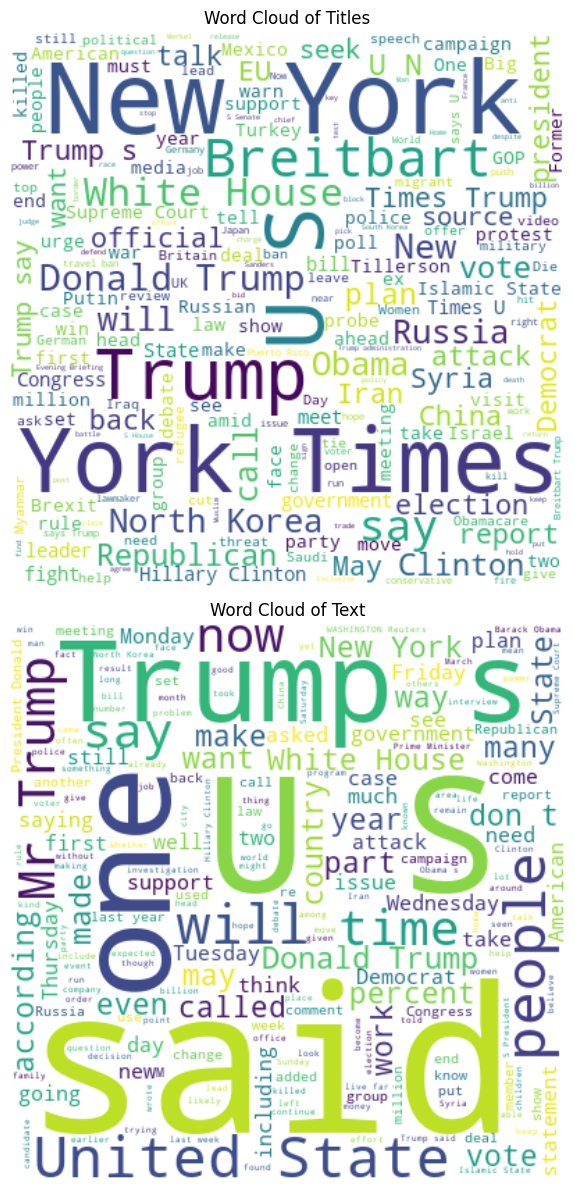

In [ ]:
# Concatenate all the text from the 'title' and 'text' columns in the filtered dataset
text_title = ' '.join(filtered_data_fake['title'].dropna())
text_text = ' '.join(filtered_data_fake['text'].dropna())

# Generate the word clouds
wordcloud_title = WordCloud(width=400, height=400, background_color='white').generate(text_title)
wordcloud_text = WordCloud(width=400, height=400, background_color='white').generate(text_text)

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(20, 12))

# Plot the first word cloud (title)
axes[0].imshow(wordcloud_title, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Word Cloud of Titles')

# Plot the second word cloud (text)
axes[1].imshow(wordcloud_text, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Word Cloud of Text')

# Adjust layout
plt.tight_layout()

# Show the combined plot
plt.show()

In [10]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Preprocess the text data
def preprocess_text(text):
    # Remove punctuation, special characters, exclamation marks, and question marks
    text = re.sub(r'[^a-zA-Z0-9\s!?]', '', text)

    # Tokenization and removing stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]

    # Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]

    # Join the processed words back into a sentence
    return ' '.join(words)

# Apply preprocessing to the text columns
data['title'] = data['title'].fillna('').apply(preprocess_text)
data['text'] = data['text'].fillna('').apply(preprocess_text)

In [13]:
from textblob import TextBlob
import re

def extract_features(df):

    df['combined_text'] = df['title'] + " " + df['text']

    # Initialize columns for the features
    df['title_length'] = df['title'].str.len()  # Length of the title
    df['text_length'] = df['text'].str.len()    # Length of the text

    df['title_sentiment'] = df['title'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)  # Sentiment of the title
    df['text_sentiment'] = df['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)    # Sentiment of the text

    # Stylistic and formatting features
    df['title_exclamation_marks'] = df['title'].str.count(r'\!')  # Count of exclamation marks in title
    df['title_question_marks'] = df['title'].str.count(r'\?')     # Count of question marks in title
    df['title_all_caps'] = df['title'].str.count(r'\b[A-Z]{2,}\b')  # Count of all caps words in title
    df['title_repeated_letters'] = df['title'].apply(lambda x: len(re.findall(r'(.)\1{2,}', str(x))))  # Count of repeated letters in text

    df['text_exclamation_marks'] = df['text'].str.count(r'\!')  # Count of exclamation marks in text
    df['text_question_marks'] = df['text'].str.count(r'\?')     # Count of question marks in text
    df['text_all_caps'] = df['text'].str.count(r'\b[A-Z]{2,}\b')  # Count of all caps words in text
    df['text_repeated_letters'] = df['text'].apply(lambda x: len(re.findall(r'(.)\1{2,}', str(x))))  # Count of repeated letters in text

    # Vocabulary analysis
    df['title_unique_words'] = df['title'].apply(lambda x: len(set(str(x).split())))  # Number of unique words in title
    df['text_unique_words'] = df['text'].apply(lambda x: len(set(str(x).split())))    # Number of unique words in text



    return df

# Extract features from the dataset
feature_data = extract_features(data)

# Display the first few rows with the new features
feature_data.head()

,title,text,label,combined_text,title_length,text_length,title_sentiment,text_sentiment,title_exclamation_marks,title_question_marks,title_all_caps,title_repeated_letters,text_exclamation_marks,text_question_marks,text_all_caps,text_repeated_letters,title_unique_words,text_unique_words
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,130,5049,0.080000,0.033103,0,0,6,0,2,7,1,10,17,425
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,137,216,0.121875,0.258929,1,0,12,0,0,0,0,1,18,31
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri...",105,8010,0.000000,0.113865,0,0,0,0,0,1,6,1,16,691
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...,95,1916,-0.287879,0.056373,0,0,2,0,0,0,16,4,16,191
5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,About Time! Christian Group Sues Amazon and SP...,78,1530,-0.400000,-0.079803,1,0,1,0,1,0,13,0,12,160


In [ ]:
scaler=StandardScaler()
norm_features=scaler.fit_transform(features_tfidf)
train_ft,test_ft,train_labels,test_labels=train_test_split(norm_features,labels,test_size=0.2, train_size=0.8)
print("----------------Train data------------------------\n")
print(" train data features shape {} \n train data labels shape {}\n".format(train_ft.shape,train_labels.shape))
print("-----------------Test data-------------------------\n")
print(" test data features shape {} \n test data labels shape {}".format(test_ft.shape,test_labels.shape))

----------------Train data------------------------

 train data features shape (57229, 114) 
 train data labels shape (57229,)

-----------------Test data-------------------------

 test data features shape (14308, 114) 
 test data labels shape (14308,)


array([[-0.42504015,  0.49386077,  0.67928326, ...,  7.17635652,
         2.82841373, -0.14837368],
       [-0.42504015,  0.26480194,  0.76155904, ...,  0.34997866,
        -0.4228514 , -0.15866192],
       [-0.42504015,  0.97725905, -0.41482626, ..., -0.33265913,
         2.57831641, -0.43644427],
       ...,
       [-0.42504015,  0.30622623, -0.41482626, ..., -0.33265913,
        -0.67294872, -0.68336193],
       [-0.42504015, -0.68928903, -0.41482626, ..., -0.33265913,
         1.07773251, -0.46730898],
       [-0.42504015, -0.68928903, -0.41482626, ...,  0.34997866,
        -0.67294872, -0.62677663]])

In [15]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense



In [14]:
feature_data['text'] = feature_data['text'].astype(str)
feature_data['text'].fillna('', inplace=True)

In [16]:
max_words = 10000
max_len = 100
#mentioning fix lengths for further

In [17]:
X = feature_data['text'].values
y = feature_data['label'].values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
#tokenization of each text from text column
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(feature_data['text'])

In [20]:
#converting the tokenizers from text string values to numeric
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [21]:
#kept all the sequences with equal length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [22]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))#convert integer-encoded words into dense vectors of mentioned fixed size.
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


mymodel=model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test))


Epoch 1/5
1789/1789 [==============================] - 107s 59ms/step - loss: 0.1943 - accuracy: 0.9252 - val_loss: 0.1540 - val_accuracy: 0.9435
Epoch 2/5
1789/1789 [==============================] - 108s 61ms/step - loss: 0.1013 - accuracy: 0.9641 - val_loss: 0.1483 - val_accuracy: 0.9488
Epoch 3/5
1789/1789 [==============================] - 108s 60ms/step - loss: 0.0670 - accuracy: 0.9764 - val_loss: 0.1554 - val_accuracy: 0.9478
Epoch 4/5
1789/1789 [==============================] - 112s 63ms/step - loss: 0.0431 - accuracy: 0.9853 - val_loss: 0.2072 - val_accuracy: 0.9356
Epoch 5/5
1789/1789 [==============================] - 100s 56ms/step - loss: 0.0280 - accuracy: 0.9909 - val_loss: 0.3056 - val_accuracy: 0.9320


In [28]:
accuracy = model.evaluate(X_test_pad, y_test)[1]
print(f"Accuracy: {accuracy}")

448/448 [==============================] - 5s 12ms/step - loss: 0.2188 - accuracy: 0.9493
Accuracy: 0.9493290185928345


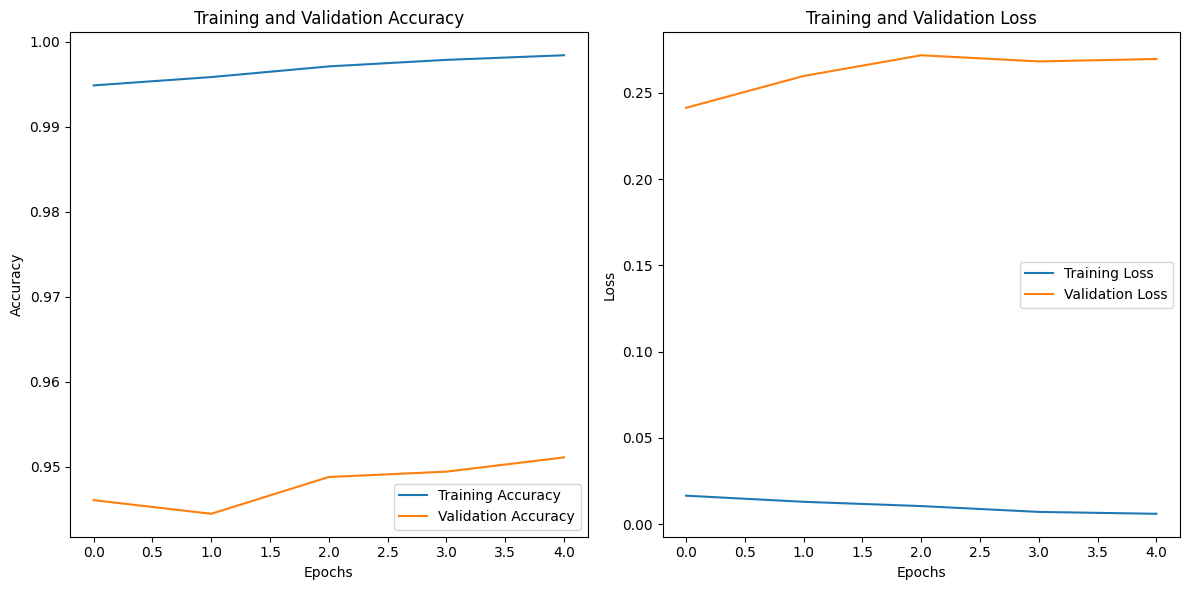

In [33]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(mymodel.history['accuracy'], label='Training Accuracy')
plt.plot(mymodel.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(mymodel.history['loss'], label='Training Loss')
plt.plot(mymodel.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [35]:
import pandas as pd
import spacy

# Load spaCy model for summarization
nlp = spacy.load('en_core_web_sm')


In [36]:

# Function for text summarization using spaCy
def summarize_text(text):
    doc = nlp(text)
    # Using the first 3 sentences as the summary (you can adjust this)
    summary = " ".join([sent.text for sent in doc.sents][:3])
    return summary

# Apply summarization function to the 'text_column' and create a new column 'summary_column'
feature_data['summary_column'] = feature_data['text'].apply(summarize_text)

feature_data

,title,text,label,combined_text,title_length,text_length,title_sentiment,text_sentiment,title_exclamation_marks,title_question_marks,title_all_caps,title_repeated_letters,text_exclamation_marks,text_question_marks,text_all_caps,text_repeated_letters,title_unique_words,text_unique_words,summary_column
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,130,5049,0.080000,0.033103,0,0,6,0,2,7,1,10,17,425,No comment is expected from Barack Obama Membe...
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,137,216,0.121875,0.258929,1,0,12,0,0,0,0,1,18,31,"Now, most of the demonstrators gathered last ..."
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri...",105,8010,0.000000,0.113865,0,0,0,0,0,1,6,1,16,691,A dozen politically active pastors came here f...
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...,95,1916,-0.287879,0.056373,0,0,2,0,0,0,16,4,16,191,"The RS-28 Sarmat missile, dubbed Satan 2, will..."
5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,About Time! Christian Group Sues Amazon and SP...,78,1530,-0.400000,-0.079803,1,0,1,0,1,0,13,0,12,160,All we can say on this one is it s about time ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0,Russians steal research on Trump in hack of U....,65,4788,0.000000,0.092339,0,0,0,0,0,0,9,2,11,415,WASHINGTON (Reuters) - Hackers believed to be ...
72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1,WATCH: Giuliani Demands That Democrats Apolog...,79,3634,0.000000,-0.044864,0,0,1,0,0,1,2,0,10,306,"You know, because in fantasyland Republicans n..."
72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0,Migrants Refuse To Leave Train At Refugee Camp...,57,2864,0.000000,0.103722,0,0,0,0,1,1,4,2,10,305,Migrants Refuse To Leave Train At Refugee Camp...
72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0,Trump tussle gives unpopular Mexican leader mu...,67,3374,0.000000,-0.019316,0,0,0,0,1,0,6,1,10,350,MEXICO CITY (Reuters) - Donald Trump’s combati...


In [37]:
X = feature_data['summary_column'].values
y = feature_data['label'].values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(feature_data['summary_column'])

In [40]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [41]:
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [42]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))#convert integer-encoded words into dense vectors of mentioned fixed size.
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


mymodel=model.fit(X_train_pad, y_train, epochs=3, batch_size=32, validation_data=(X_test_pad, y_test))

Epoch 1/3
1789/1789 [==============================] - 140s 77ms/step - loss: 0.2634 - accuracy: 0.8974 - val_loss: 0.1908 - val_accuracy: 0.9298
Epoch 2/3
1789/1789 [==============================] - 131s 73ms/step - loss: 0.1314 - accuracy: 0.9524 - val_loss: 0.1710 - val_accuracy: 0.9425
Epoch 3/3
1789/1789 [==============================] - 133s 74ms/step - loss: 0.0859 - accuracy: 0.9693 - val_loss: 0.1560 - val_accuracy: 0.9410


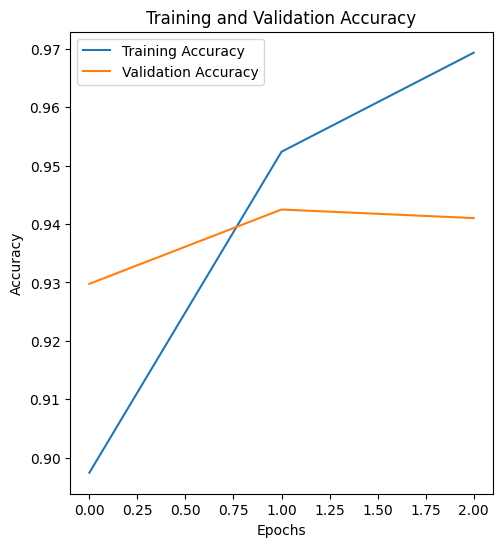

In [44]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(mymodel.history['accuracy'], label='Training Accuracy')
plt.plot(mymodel.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
